In [1]:
import pandas as pd
import utils_max_flow as utils
import pickle

In [2]:
with open('graph_objects/G_simple_directed_iggielgn.pickle', 'rb') as f:
    G_simple_directed = pickle.load(f)
    G_simple_directed.name = 'G_simple_directed'

In [3]:
# Dataset; 'iggin' or 'iggielgn'
dataset = 'iggielgn'

# S-t-flow; 's-t-degree' or 's-t-type'
s_t_flow = 'hybrid'

In [4]:
# Toggle to run N-k or just print stored results
run_analysis = False

----
# Heuristics

### Node removal

In [5]:
if run_analysis:
    random_node_removal_df = utils.flow_capacity_robustness(G_simple_directed, heuristic='random', remove='node')
    random_node_removal_df.to_pickle('results/max_flow/'+dataset+'/'+s_t_flow+'/random_node_removal_df.pkl')
# random_node_removal_df = pd.read_pickle('results/max_flow/'+dataset+'/'+s_t_flow+'/random_node_removal_df.pkl')

In [6]:
if run_analysis:
    load_rate_node_removal_df = utils.flow_capacity_robustness(G_simple_directed, heuristic='load_rate', remove='node')
    load_rate_node_removal_df.to_pickle('results/max_flow/'+dataset+'/'+s_t_flow+'/load_rate_node_removal_df.pkl')
load_rate_node_removal_df = pd.read_pickle('results/max_flow/'+dataset+'/'+s_t_flow+'/load_rate_node_removal_df.pkl')
utils.results_summary(load_rate_node_removal_df)

Heuristic: load_rate

First entity removals:
----------------------------------------------
 it  removed_entity     diff  pct_change
  1       LKD_N_199    -0.00         0.0
  2         NO_N_17 38566.52       -37.7
  3    N_791_S_LMGN  5691.94        -8.9
  4 SEQ_369__L_LMGN 12096.98       -20.9
  5        LKD_N_97  5600.33       -12.2

Entity removals causing most damage, measured by: max_flow_value
----------------------------------------------
 it  removed_entity     diff  pct_change
  2         NO_N_17 38566.52       -37.7
  4 SEQ_369__L_LMGN 12096.98       -20.9
  3    N_791_S_LMGN  5691.94        -8.9
  5        LKD_N_97  5600.33       -12.2
  8   N_153_NS_LMGN  5281.02       -15.6


Summary statistics (first 150 removals)
----------------------------------------------
Percentage network damage: 100.0%
Mean damage per entity removal: 13447.36
Variation in damage per entity removal: 14328.36
The metric reaches 0 at iteration 59.


In [7]:
if run_analysis:
    max_flow_node_removal_df = utils.flow_capacity_robustness(G_simple_directed, heuristic='max_flow', remove='node')
    max_flow_node_removal_df.to_pickle('results/max_flow/'+dataset+'/'+s_t_flow+'/max_flow_node_removal_df.pkl')
max_flow_node_removal_df = pd.read_pickle('results/max_flow/'+dataset+'/'+s_t_flow+'/max_flow_node_removal_df.pkl')
utils.results_summary(max_flow_node_removal_df)

Heuristic: max_flow_edge_flows

First entity removals:
----------------------------------------------
 it  removed_entity     diff  pct_change
  1       LKD_N_164 28757.17       -28.1
  2    N_730_M_LMGN 20514.15       -27.9
  3 SEQ_369__L_LMGN 12096.98       -22.8
  4    N_539_M_LMGN  9289.55       -22.7
  5       LKD_N_166  1622.72        -5.1

Entity removals causing most damage, measured by: max_flow_value
----------------------------------------------
 it  removed_entity     diff  pct_change
  1       LKD_N_164 28757.17       -28.1
  2    N_730_M_LMGN 20514.15       -27.9
  3 SEQ_369__L_LMGN 12096.98       -22.8
  4    N_539_M_LMGN  9289.55       -22.7
  8      SEQ_1979_p  4645.14       -18.0


Summary statistics (first 150 removals)
----------------------------------------------
Percentage network damage: 100.0%
Mean damage per entity removal: 15060.6
Variation in damage per entity removal: 9590.45
The metric reaches 0 at iteration 50.


In [8]:
if run_analysis:
    max_flow_edge_count_node_removal_df = utils.flow_capacity_robustness(G_simple_directed, heuristic='max_flow_edge_count', remove='node')
    max_flow_edge_count_node_removal_df.to_pickle('results/max_flow/'+dataset+'/'+s_t_flow+'/max_flow_edge_count_node_removal_df.pkl')
max_flow_edge_count_node_removal_df = pd.read_pickle('results/max_flow/'+dataset+'/'+s_t_flow+'/max_flow_edge_count_node_removal_df.pkl')
utils.results_summary(max_flow_edge_count_node_removal_df)

Heuristic: max_flow_edge_count

First entity removals:
----------------------------------------------
 it  removed_entity     diff  pct_change
  1       LKD_N_165 34198.92       -33.4
  2    N_730_M_LMGN 20456.34       -30.0
  3    N_539_M_LMGN  9098.95       -19.1
  4 SEQ_369__L_LMGN 12096.98       -31.4
  5   N_211_NS_LMGN  5307.60       -20.1

Entity removals causing most damage, measured by: max_flow_value
----------------------------------------------
 it  removed_entity     diff  pct_change
  1       LKD_N_165 34198.92       -33.4
  2    N_730_M_LMGN 20456.34       -30.0
  4 SEQ_369__L_LMGN 12096.98       -31.4
  3    N_539_M_LMGN  9098.95       -19.1
  5   N_211_NS_LMGN  5307.60       -20.1


Summary statistics (first 150 removals)
----------------------------------------------
Percentage network damage: 100.0%
Mean damage per entity removal: 16231.76
Variation in damage per entity removal: 11488.87
The metric reaches 0 at iteration 50.


In [9]:
if run_analysis:
    wfcr_node_removal_df = utils.flow_capacity_robustness(G_simple_directed, heuristic='wfcr', remove='node')
    wfcr_node_removal_df.to_pickle('results/max_flow/'+dataset+'/'+s_t_flow+'/wfcr_node_removal_df.pkl')
wfcr_node_removal_df = pd.read_pickle('results/max_flow/'+dataset+'/'+s_t_flow+'/wfcr_node_removal_df.pkl')
utils.results_summary(wfcr_node_removal_df, 'capacity_robustness_max_flow')

Heuristic: entity criticality index

First entity removals:
----------------------------------------------
 it  removed_entity  diff  pct_change
  1         NO_N_17  0.38       -38.0
  2 SEQ_369__L_LMGN  0.12       -19.3
  3    N_730_M_LMGN  0.14       -27.7
  4       LKD_N_199  0.00        -0.0
  5   N_211_NS_LMGN  0.05       -13.7

Entity removals causing most damage, measured by: capacity_robustness_max_flow
----------------------------------------------
 it  removed_entity  diff  pct_change
  1         NO_N_17  0.38       -38.0
  3    N_730_M_LMGN  0.14       -27.7
  2 SEQ_369__L_LMGN  0.12       -19.3
  5   N_211_NS_LMGN  0.05       -13.7
  6     SEQ_10483_p  0.05       -16.1


Summary statistics (first 150 removals)
----------------------------------------------
Percentage network damage: 100.0%
Mean damage per entity removal: 0.15
Variation in damage per entity removal: 0.14
The metric reaches 0 at iteration 50.


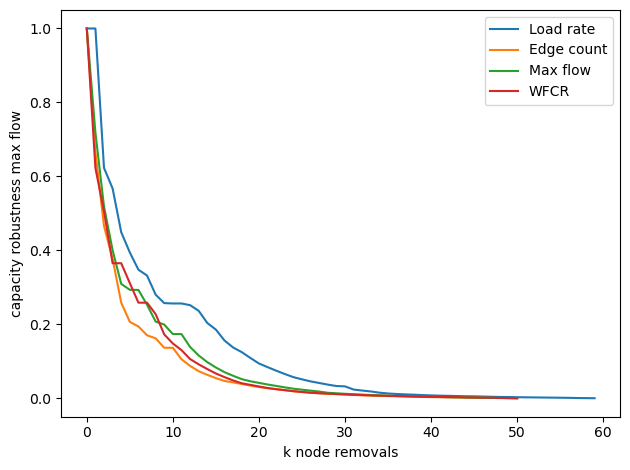

In [10]:
fig = utils.plot_heuristic_comparison_biplot([load_rate_node_removal_df, max_flow_edge_count_node_removal_df, max_flow_node_removal_df, wfcr_node_removal_df])
fig.savefig('saved_plots/'+dataset+'/'+s_t_flow+'/max_flow/node_removals.png')

### Edge removal

In [11]:
if run_analysis:
    random_edge_removal_df = utils.flow_capacity_robustness(G_simple_directed, heuristic='random', remove='edge')
    random_edge_removal_df.to_pickle('results/max_flow/'+dataset+'/'+s_t_flow+'/random_edge_removal_df.pkl')
# random_edge_removal_df = pd.read_pickle('results/max_flow/'+dataset+'/'+s_t_flow+'/random_edge_removal_df.pkl')

In [12]:
if run_analysis:
    load_rate_edge_removal_df = utils.flow_capacity_robustness(G_simple_directed, heuristic='load_rate', remove='edge')
    load_rate_edge_removal_df.to_pickle('results/max_flow/'+dataset+'/'+s_t_flow+'/load_rate_edge_removal_df.pkl')
load_rate_edge_removal_df = pd.read_pickle('results/max_flow/'+dataset+'/'+s_t_flow+'/load_rate_edge_removal_df.pkl')
utils.results_summary(load_rate_edge_removal_df) 

Heuristic: load_rate

First entity removals:
----------------------------------------------
 it                   removed_entity     diff  pct_change
  1           {LKD_N_199, LKD_N_104}    -0.00         0.0
  2            {SEQ_2285_p, NO_N_17} 23062.04       -22.5
  3 {SEQ_8387__L_LMGN, N_791_S_LMGN} 11951.79       -15.1
  4    {SEQ_8163__M_LMGN, SEQ_444_p}  4310.00        -6.4
  5            {LKD_N_97, LKD_N_516}  2913.65        -4.6

Entity removals causing most damage, measured by: max_flow_value
----------------------------------------------
 it                     removed_entity     diff  pct_change
  2              {SEQ_2285_p, NO_N_17} 23062.04       -22.5
  9 {SEQ_369__L_LMGN, SEQ_373__L_LMGN} 12096.98       -22.4
  3   {SEQ_8387__L_LMGN, N_791_S_LMGN} 11951.79       -15.1
 10     {N_153_NS_LMGN, N_150_NS_LMGN}  6031.85       -14.4
 11   {SEQ_7053__M_LMGN, N_539_M_LMGN}  5102.16       -14.3


Summary statistics (first 150 removals)
---------------------------------------------

In [13]:
if run_analysis:
    max_flow_edge_removal_df = utils.flow_capacity_robustness(G_simple_directed, heuristic='max_flow', remove='edge')
    max_flow_edge_removal_df.to_pickle('results/max_flow/'+dataset+'/'+s_t_flow+'/max_flow_edge_removal_df.pkl')
max_flow_edge_removal_df = pd.read_pickle('results/max_flow/'+dataset+'/'+s_t_flow+'/max_flow_edge_removal_df.pkl')
utils.results_summary(max_flow_edge_removal_df)

Heuristic: max_flow_edge_flows

First entity removals:
----------------------------------------------
 it                     removed_entity     diff  pct_change
  1             {LKD_N_165, LKD_N_164} 28757.17       -28.1
  2       {N_731_M_LMGN, N_730_M_LMGN} 20396.51       -27.7
  3 {SEQ_369__L_LMGN, SEQ_373__L_LMGN} 12096.98       -22.8
  4   {SEQ_7053__M_LMGN, N_539_M_LMGN}  9289.55       -22.6
  5             {LKD_N_199, LKD_N_166}    -0.00         0.0

Entity removals causing most damage, measured by: max_flow_value
----------------------------------------------
 it                     removed_entity     diff  pct_change
  1             {LKD_N_165, LKD_N_164} 28757.17       -28.1
  2       {N_731_M_LMGN, N_730_M_LMGN} 20396.51       -27.7
  3 {SEQ_369__L_LMGN, SEQ_373__L_LMGN} 12096.98       -22.8
  4   {SEQ_7053__M_LMGN, N_539_M_LMGN}  9289.55       -22.6
  7       {N_224_S_LMGN, N_304_M_LMGN}  5311.73       -16.7


Summary statistics (first 150 removals)
-----------------------

In [14]:
if run_analysis:
    max_flow_edge_count_edge_removal_df = utils.flow_capacity_robustness(G_simple_directed, heuristic='max_flow_edge_count', remove='edge')
    max_flow_edge_count_edge_removal_df.to_pickle('results/max_flow/'+dataset+'/'+s_t_flow+'/max_flow_edge_count_edge_removal_df.pkl')
max_flow_edge_count_edge_removal_df = pd.read_pickle('results/max_flow/'+dataset+'/'+s_t_flow+'/max_flow_edge_count_edge_removal_df.pkl')
utils.results_summary(max_flow_edge_count_edge_removal_df)

Heuristic: max_flow_edge_count

First entity removals:
----------------------------------------------
 it                  removed_entity   diff  pct_change
  1        {SEQ_11378_p, LKD_N_165} 261.53        -0.3
  2           {LKD_N_51, LKD_N_104}  -0.00         0.0
  3 {SEQ_7989__M_LMGN, SEQ_11392_p} 402.15        -0.4
  4          {LKD_N_687, LKD_N_685}  12.52        -0.0
  5          {LKD_N_688, LKD_N_687} 386.39        -0.4

Entity removals causing most damage, measured by: max_flow_value
----------------------------------------------
 it                     removed_entity     diff  pct_change
  7   {SEQ_715__L_LMGN, N_1609_S_LMGN} 48646.84       -48.1
  9 {SEQ_369__L_LMGN, SEQ_373__L_LMGN} 12096.98       -28.5
  8   {SEQ_7053__M_LMGN, N_539_M_LMGN} 10027.05       -19.1
 17   {N_684_M_LMGN, SEQ_7685__M_LMGN}  3170.24       -18.6
 13   {N_541_M_LMGN, SEQ_9815__M_LMGN}  3104.55       -12.3


Summary statistics (first 150 removals)
----------------------------------------------
Percen

In [15]:
if run_analysis:
    wfcr_edge_removal_df = utils.flow_capacity_robustness(G_simple_directed, heuristic='wfcr', remove='edge')
    wfcr_edge_removal_df.to_pickle('results/max_flow/'+dataset+'/'+s_t_flow+'/wfcr_edge_removal_df.pkl')
wfcr_edge_removal_df = pd.read_pickle('results/max_flow/'+dataset+'/'+s_t_flow+'/wfcr_edge_removal_df.pkl')
utils.results_summary(wfcr_edge_removal_df, 'capacity_robustness_max_flow') 

Heuristic: entity criticality index

First entity removals:
----------------------------------------------
 it                     removed_entity  diff  pct_change
  1              {SEQ_2285_p, NO_N_17}  0.23       -23.0
  2 {SEQ_369__L_LMGN, SEQ_373__L_LMGN}  0.12       -15.5
  3   {SEQ_8387__L_LMGN, N_791_S_LMGN}  0.12       -18.3
  4     {N_153_NS_LMGN, N_150_NS_LMGN}  0.09       -16.7
  5             {LKD_N_199, LKD_N_104} -0.00         0.0

Entity removals causing most damage, measured by: capacity_robustness_max_flow
----------------------------------------------
 it                     removed_entity  diff  pct_change
  1              {SEQ_2285_p, NO_N_17}  0.23       -23.0
  2 {SEQ_369__L_LMGN, SEQ_373__L_LMGN}  0.12       -15.5
  3   {SEQ_8387__L_LMGN, N_791_S_LMGN}  0.12       -18.3
  4     {N_153_NS_LMGN, N_150_NS_LMGN}  0.09       -16.7
  6      {SEQ_8163__M_LMGN, SEQ_444_p}  0.05       -11.0


Summary statistics (first 150 removals)
----------------------------------------

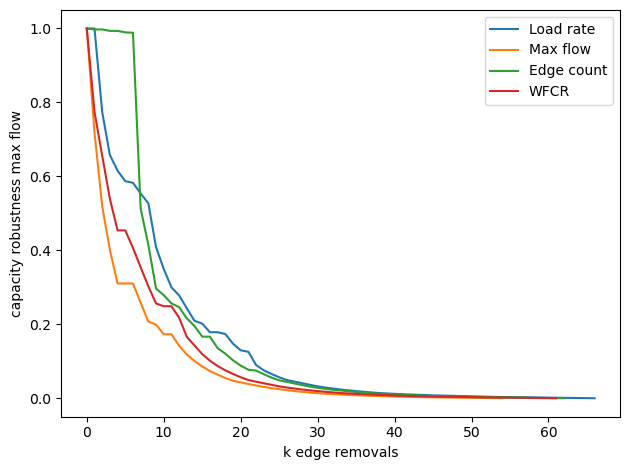

In [16]:
fig = utils.plot_heuristic_comparison_biplot([load_rate_edge_removal_df, max_flow_edge_removal_df, max_flow_edge_count_edge_removal_df, wfcr_edge_removal_df])
fig.savefig('saved_plots/'+dataset+'/'+s_t_flow+'/max_flow/edge_removals.png')